# D1 — Provider Review Queue (Decision Notebook)

**Decision Supported:** D-PI-1 — Provider Review Entry
**Decision Actor:** Program Integrity (PI)
**Decision Owner:** Investigations Lead / Program Integrity Analytics Manager
**Notebook Type:** Decision — parameterized recommendation output

---

## Organizational Reference Notice

> Organizational roles and structures referenced in this document are based on the
> CMS Organizational Chart dated April 22, 2025. Structure is subject to change.
> Data references are based on CMS Medicare Part B PUF, RY25/D23.
> Readers should verify current organizational alignment independently.

---

## Why This Notebook Exists

The Center for Program Integrity must decide which providers enter the
review queue given finite enforcement resources and large national claim volumes.

This notebook does not detect anomalies.
That work is done in the core signal engine.

This notebook does one thing:

**Translate evidence into a defensible, parameterized operational recommendation
for the Investigations Lead.**

---

## What This Notebook Does NOT Do

- Does not recompute signals or Z-scores
- Does not produce new analytical outputs
- Does not assert fraud, waste, or abuse
- Does not make final enforcement decisions

---

## How to Use This Notebook

Three parameters control the recommendation:

| Parameter | What It Controls | Default |
|---|---|---|
| `Z_THRESHOLD` | Minimum Z-score to count a signal as flagged | 2.0 |
| `MIN_SIGNALS` | Minimum flagged signals required for Tier 1 | 3 |
| `QUEUE_SIZE` | Maximum providers to include in active review queue | 500 |

Adjust these parameters to reflect operational capacity and risk tolerance.
The recommendation updates automatically.

All outputs are tagged:
- O = Observed
- D = Derived
- I = Inferred
- A = Assumed

**No output asserts provider intent, fraud, or wrongdoing.**

In [13]:
# CELL-ID: D1-DPI1-PARAMS-01
# PURPOSE: Define decision parameters controlling the review queue recommendation
# INPUTS: None — analyst-controlled parameters
# OUTPUTS: Parameter variables used by all downstream cells in this notebook
# DECISION-LINK: D-PI-1 Provider Review Entry
# NOTE: Adjust these values to reflect operational capacity and risk tolerance
# ASSUMED (A): Default values represent standard statistical and operational starting points

# ── Decision Parameters ──────────────────────────────────────────────────────

# Z-score threshold: minimum peer-adjusted deviation to count a signal as flagged
# Lower = more sensitive (more flags), Higher = more conservative (fewer flags)
Z_THRESHOLD = 2.0

# Minimum signals flagged: how many independent signals must agree for Tier 1
# Higher = stronger evidence requirement, fewer providers flagged
MIN_SIGNALS = 3

# Queue size: maximum providers to include in the active review queue
# Reflects operational review capacity per cycle
QUEUE_SIZE = 500

# ── Parameter Summary ────────────────────────────────────────────────────────
print("Decision Parameters (A — Assumed):")
print(f"  Z_THRESHOLD  : {Z_THRESHOLD} standard deviations above peer mean")
print(f"  MIN_SIGNALS  : {MIN_SIGNALS} independent signals required for Tier 1")
print(f"  QUEUE_SIZE   : {QUEUE_SIZE} providers maximum in active review queue")
print()
print("Adjust these values to reflect:")
print("  - Operational review capacity (QUEUE_SIZE)")
print("  - Risk tolerance (Z_THRESHOLD)")
print("  - Evidence strength requirement (MIN_SIGNALS)")

Decision Parameters (A — Assumed):
  Z_THRESHOLD  : 2.0 standard deviations above peer mean
  MIN_SIGNALS  : 3 independent signals required for Tier 1
  QUEUE_SIZE   : 500 providers maximum in active review queue

Adjust these values to reflect:
  - Operational review capacity (QUEUE_SIZE)
  - Risk tolerance (Z_THRESHOLD)
  - Evidence strength requirement (MIN_SIGNALS)


In [14]:
# CELL-ID: D1-DPI1-ENGINE-01
# PURPOSE: Apply decision parameters to signal scores and produce parameterized review queue
# INPUTS: data/processed/provider_signal_scores_v1.parquet, D1-DPI1-PARAMS-01
# OUTPUTS: Parameterized review queue dataframe + summary statistics
# DECISION-LINK: D-PI-1 Provider Review Entry
# NOTE: Derived (D) — applies analyst-controlled parameters to peer-adjusted scores

from pathlib import Path
import pyarrow.parquet as pq

PROJECT_ROOT = Path(r"C:\Users\billm\Projects\Medicare\medicare-program-integrity")
SCORES_PATH = PROJECT_ROOT / "data" / "processed" / "provider_signal_scores_v1.parquet"

df = pq.read_table(SCORES_PATH).to_pandas()

zscore_cols = [
    "S1_allowed_per_bene_zscore",
    "S2_payment_per_bene_zscore",
    "S3_services_per_bene_zscore",
    "S4_submitted_to_allowed_ratio_zscore",
    "S5a_top1_allowed_share_zscore",
    "S5b_top1_payment_share_zscore",
    "S6_payment_to_allowed_ratio_zscore",
    "S7_allowed_minus_payment_per_bene_zscore",
]

# Apply parameters from D1-DPI1-PARAMS-01
df["signals_flagged"] = (df[zscore_cols] >= Z_THRESHOLD).sum(axis=1)

# Tier assignment using MIN_SIGNALS parameter
def assign_tier(n):
    if n >= MIN_SIGNALS:
        return "Tier1_Review"
    elif n == MIN_SIGNALS - 1:
        return "Tier2_Monitor"
    elif n == 1:
        return "Tier3_Watch"
    else:
        return "No_Flag"

df["anomaly_tier"] = df["signals_flagged"].apply(assign_tier)

# Isolate Tier 1 and apply QUEUE_SIZE parameter
tier1 = df[df["anomaly_tier"] == "Tier1_Review"].copy()
tier1 = tier1.sort_values("allowed_dollars_sum", ascending=False).reset_index(drop=True)
tier1["review_rank"] = tier1.index + 1
queue = tier1.head(QUEUE_SIZE).copy()

# ── Recommendation Summary ───────────────────────────────────────────────────
total_providers     = len(df)
tier1_total         = len(tier1)
queue_total         = len(queue)
queue_allowed       = queue["allowed_dollars_sum"].sum()
tier1_allowed       = tier1["allowed_dollars_sum"].sum()
all_allowed         = df["allowed_dollars_sum"].sum()
queue_allowed_pct   = (queue_allowed / all_allowed) * 100
tier1_allowed_pct   = (tier1_allowed / all_allowed) * 100

print("=" * 60)
print("DECISION RECOMMENDATION — D-PI-1 Provider Review Entry")
print("Actor: Program Integrity (PI)")
print("Owner: Investigations Lead")
print("=" * 60)
print()
print("── Parameters Applied (A) ──────────────────────────────")
print(f"  Z_THRESHOLD  : {Z_THRESHOLD}")
print(f"  MIN_SIGNALS  : {MIN_SIGNALS}")
print(f"  QUEUE_SIZE   : {QUEUE_SIZE}")
print()
print("── Signal Engine Results (D) ───────────────────────────")
print(f"  Total providers evaluated : {total_providers:>10,}")
print(f"  Tier 1 flagged            : {tier1_total:>10,}")
print(f"  Tier 1 as % of total      : {tier1_allowed_pct:>9.1f}%  of allowed dollars")
print()
print("── Active Review Queue (D) ─────────────────────────────")
print(f"  Queue size                : {queue_total:>10,}  providers")
print(f"  Queue allowed dollars     : ${queue_allowed:>14,.0f}")
print(f"  Queue as % of all allowed : {queue_allowed_pct:>9.1f}%")
print()
print("── Recommendation (I) ──────────────────────────────────")
print(f"  Initiate focused review for top {queue_total:,} providers.")
print(f"  These providers represent {queue_allowed_pct:.1f}% of total")
print(f"  allowed dollars while comprising")
print(f"  {(queue_total/total_providers)*100:.2f}% of the provider population.")
print()
print("── Uncertainty Notice ──────────────────────────────────")
print("  Signals describe peer-adjusted statistical patterns.")
print("  No assertion of fraud, waste, or abuse is made.")
print("  Thresholds reflect analytical assumptions (A).")
print("  Recommend quarterly calibration review.")
print("=" * 60)

DECISION RECOMMENDATION — D-PI-1 Provider Review Entry
Actor: Program Integrity (PI)
Owner: Investigations Lead

── Parameters Applied (A) ──────────────────────────────
  Z_THRESHOLD  : 2.0
  MIN_SIGNALS  : 3
  QUEUE_SIZE   : 500

── Signal Engine Results (D) ───────────────────────────
  Total providers evaluated :    970,848
  Tier 1 flagged            :     22,400
  Tier 1 as % of total      :       6.4%  of allowed dollars

── Active Review Queue (D) ─────────────────────────────
  Queue size                :        500  providers
  Queue allowed dollars     : $ 1,770,070,918
  Queue as % of all allowed :       2.6%

── Recommendation (I) ──────────────────────────────────
  Initiate focused review for top 500 providers.
  These providers represent 2.6% of total
  allowed dollars while comprising
  0.05% of the provider population.

── Uncertainty Notice ──────────────────────────────────
  Signals describe peer-adjusted statistical patterns.
  No assertion of fraud, waste, or abu

In [9]:
# CELL-ID: D1-DPI1-SENSITIVITY-01
# PURPOSE: Show how queue size and allowed dollars captured change across parameter ranges
# INPUTS: provider_signal_scores_v1.parquet, zscore_cols
# OUTPUTS: Sensitivity table printed to console
# DECISION-LINK: D-PI-1 Provider Review Entry
# NOTE: Derived (D) — illustrates decision sensitivity to analytical assumptions

import pandas as pd

sensitivity_rows = []

for z in [1.5, 2.0, 2.5, 3.0]:
    for min_sig in [2, 3, 4]:
        for q_size in [250, 500, 1000]:
            flagged = (df[zscore_cols] >= z).sum(axis=1)
            tier1 = df[flagged >= min_sig].sort_values(
                "allowed_dollars_sum", ascending=False
            ).head(q_size)

            sensitivity_rows.append({
                "Z_Threshold": z,
                "Min_Signals": min_sig,
                "Queue_Size": q_size,
                "Tier1_Total": int((flagged >= min_sig).sum()),
                "Queue_Providers": len(tier1),
                "Queue_Allowed_B": round(tier1["allowed_dollars_sum"].sum() / 1e9, 3),
                "Queue_Pct_of_All": round(
                    tier1["allowed_dollars_sum"].sum() /
                    df["allowed_dollars_sum"].sum() * 100, 2
                ),
            })

sensitivity_df = pd.DataFrame(sensitivity_rows)

print("SENSITIVITY TABLE — D-PI-1 Parameter Calibration")
print("Decision Actor: Program Integrity (PI)")
print("All dollar figures in billions USD")
print("=" * 75)
print(sensitivity_df.to_string(index=False))
print()
print("Current parameters marked with >>:")
current = sensitivity_df[
    (sensitivity_df["Z_Threshold"] == Z_THRESHOLD) &
    (sensitivity_df["Min_Signals"] == MIN_SIGNALS) &
    (sensitivity_df["Queue_Size"] == QUEUE_SIZE)
]
print(current.to_string(index=False))

SENSITIVITY TABLE — D-PI-1 Parameter Calibration
Decision Actor: Program Integrity (PI)
All dollar figures in billions USD
 Z_Threshold  Min_Signals  Queue_Size  Tier1_Total  Queue_Providers  Queue_Allowed_B  Queue_Pct_of_All
         1.5            2         250       115871              250            2.824              4.23
         1.5            2         500       115871              500            3.289              4.92
         1.5            2        1000       115871             1000            3.922              5.87
         1.5            3         250        47828              250            1.810              2.71
         1.5            3         500        47828              500            2.229              3.34
         1.5            3        1000        47828             1000            2.803              4.20
         1.5            4         250        17949              250            1.509              2.26
         1.5            4         500        17949   

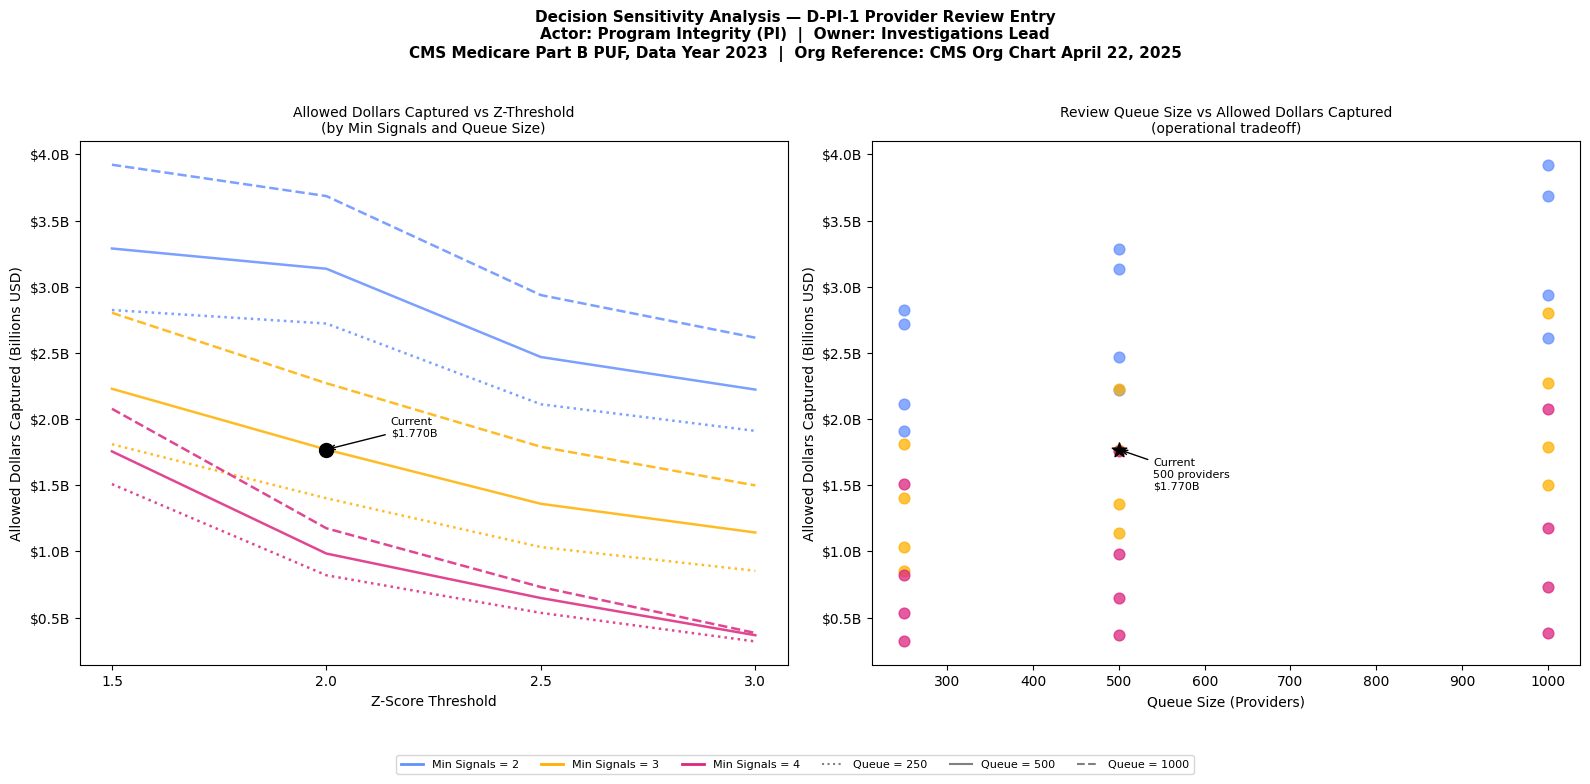

Sensitivity visualization saved: C:\Users\billm\Projects\Medicare\medicare-program-integrity\outputs\figures\decision_sensitivity_v1.png


In [10]:
# CELL-ID: D1-DPI1-VIZ-01
# PURPOSE: Visualize sensitivity of review queue to parameter choices
# INPUTS: sensitivity_df from D1-DPI1-SENSITIVITY-01, Z_THRESHOLD, MIN_SIGNALS, QUEUE_SIZE
# OUTPUTS: outputs/figures/decision_sensitivity_v1.png
# DECISION-LINK: D-PI-1 Provider Review Entry
# NOTE: Derived (D) — visual representation of parameter sensitivity analysis
# Colorblind-safe palette (IBM Carbon accessible)

from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.lines as mlines

# Re-establish root explicitly (decision notebooks must be self-contained)
PROJECT_ROOT = Path(r"C:\Users\billm\Projects\Medicare\medicare-program-integrity")
FIGURES_DIR = PROJECT_ROOT / "outputs" / "figures"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Colorblind-safe palette (IBM Carbon accessible)
COLORS = {
    2: "#648FFF",   # blue
    3: "#FFB000",   # amber
    4: "#DC267F",   # magenta
}

LINE_STYLES = {
    250:  "dotted",
    500:  "solid",
    1000: "dashed",
}

fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle(
    "Decision Sensitivity Analysis — D-PI-1 Provider Review Entry\n"
    "Actor: Program Integrity (PI)  |  Owner: Investigations Lead\n"
    "CMS Medicare Part B PUF, Data Year 2023  |  "
    "Org Reference: CMS Org Chart April 22, 2025",
    fontsize=11, fontweight="bold", y=1.02
)

z_values = sorted(sensitivity_df["Z_Threshold"].unique())

# ── Panel 1: Allowed dollars captured vs Z-threshold ─────────────────────────
ax1 = axes[0]
for min_sig, color in COLORS.items():
    for q_size, ls in LINE_STYLES.items():
        subset = sensitivity_df[
            (sensitivity_df["Min_Signals"] == min_sig) &
            (sensitivity_df["Queue_Size"] == q_size)
        ].sort_values("Z_Threshold")
        ax1.plot(
            subset["Z_Threshold"],
            subset["Queue_Allowed_B"],
            color=color,
            linestyle=ls,
            linewidth=1.8,
            alpha=0.85,
        )

# Mark current parameters
current_val = sensitivity_df[
    (sensitivity_df["Z_Threshold"] == Z_THRESHOLD) &
    (sensitivity_df["Min_Signals"] == MIN_SIGNALS) &
    (sensitivity_df["Queue_Size"] == QUEUE_SIZE)
]["Queue_Allowed_B"].values[0]

ax1.scatter(
    [Z_THRESHOLD], [current_val],
    color="black", zorder=5, s=100,
    label=f"Current parameters\n${current_val:.3f}B"
)
ax1.annotate(
    f"Current\n${current_val:.3f}B",
    xy=(Z_THRESHOLD, current_val),
    xytext=(Z_THRESHOLD + 0.15, current_val + 0.1),
    fontsize=8, color="black",
    arrowprops=dict(arrowstyle="->", color="black", lw=1.0)
)

ax1.set_title(
    "Allowed Dollars Captured vs Z-Threshold\n(by Min Signals and Queue Size)",
    fontsize=10
)
ax1.set_xlabel("Z-Score Threshold")
ax1.set_ylabel("Allowed Dollars Captured (Billions USD)")
ax1.yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda x, _: f"${x:.1f}B")
)
ax1.set_xticks(z_values)

# ── Panel 2: Queue providers vs allowed dollars ───────────────────────────────
ax2 = axes[1]
for min_sig, color in COLORS.items():
    subset = sensitivity_df[sensitivity_df["Min_Signals"] == min_sig]
    ax2.scatter(
        subset["Queue_Providers"],
        subset["Queue_Allowed_B"],
        color=color,
        alpha=0.75,
        s=60,
        label=f"Min Signals = {min_sig}"
    )

# Mark current
current_row = sensitivity_df[
    (sensitivity_df["Z_Threshold"] == Z_THRESHOLD) &
    (sensitivity_df["Min_Signals"] == MIN_SIGNALS) &
    (sensitivity_df["Queue_Size"] == QUEUE_SIZE)
]
ax2.scatter(
    current_row["Queue_Providers"],
    current_row["Queue_Allowed_B"],
    color="black", zorder=5, s=120,
    marker="*", label="Current parameters"
)
ax2.annotate(
    f"Current\n{QUEUE_SIZE} providers\n${current_val:.3f}B",
    xy=(
        current_row["Queue_Providers"].values[0],
        current_row["Queue_Allowed_B"].values[0]
    ),
    xytext=(
        current_row["Queue_Providers"].values[0] + 40,
        current_row["Queue_Allowed_B"].values[0] - 0.3
    ),
    fontsize=8, color="black",
    arrowprops=dict(arrowstyle="->", color="black", lw=1.0)
)

ax2.set_title(
    "Review Queue Size vs Allowed Dollars Captured\n(operational tradeoff)",
    fontsize=10
)
ax2.set_xlabel("Queue Size (Providers)")
ax2.set_ylabel("Allowed Dollars Captured (Billions USD)")
ax2.yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda x, _: f"${x:.1f}B")
)

# ── Shared legend ─────────────────────────────────────────────────────────────
color_handles = [
    mlines.Line2D([], [], color=c, linewidth=2, label=f"Min Signals = {s}")
    for s, c in COLORS.items()
]
style_handles = [
    mlines.Line2D([], [], color="gray", linestyle=ls,
                  linewidth=1.5, label=f"Queue = {q}")
    for q, ls in LINE_STYLES.items()
]
fig.legend(
    handles=color_handles + style_handles,
    loc="lower center",
    ncol=6,
    fontsize=8,
    bbox_to_anchor=(0.5, -0.08)
)

plt.tight_layout()
out_path = FIGURES_DIR / "decision_sensitivity_v1.png"
plt.savefig(out_path, dpi=150, bbox_inches="tight")
plt.show()
print(f"Sensitivity visualization saved: {out_path}")

In [22]:
# CELL-ID: D1-DPI1-DIAG-01
# PURPOSE: Diagnose extreme Z-score providers to address Uncertainty U5
#          (Are outliers artifacts of data suppression or real patterns?)
# INPUTS: data/processed/provider_signal_scores_v1.parquet (explicitly reloaded)
# OUTPUTS: Console diagnostic table — top 20 extreme Z-score providers
# DECISION-LINK: D-PI-1 Provider Review Entry
# NOTE: Inferred (I) — pattern interpretation, not finding of wrongdoing
#
# ── Why This Cell Exists ─────────────────────────────────────────────────────
# Visualization D1-DPI1-VIZ-01 revealed Z-scores reaching 10+ standard
# deviations in the S1 signal distribution. This is analytically unusual.
# Before the recommendation memo is written, we must determine whether
# these extreme values represent genuine billing intensity patterns or
# artifacts of peer group size, data suppression, or aggregation mechanics.
# This directly addresses U5 from the D-PI-1 decision charter.
# ─────────────────────────────────────────────────────────────────────────────

import pandas as pd
from pathlib import Path
import pyarrow.parquet as pq

PROJECT_ROOT = Path(r"C:\Users\billm\Projects\Medicare\medicare-program-integrity")
SCORES_PATH = PROJECT_ROOT / "data" / "processed" / "provider_signal_scores_v1.parquet"

# Explicitly reload filtered scores (MIN_BENES=50 applied in DPI1-02-OUTLIER-01)
df = pq.read_table(SCORES_PATH).to_pandas()

# Confirm filter held before anything else runs
print(f"Rows in scores file: {len(df):,}")
print(f"Min Tot_Benes_sum in file: {df['Tot_Benes_sum'].min()}")
print()

# ── Hardcoding Notice ────────────────────────────────────────────────────────
# EXTREME_Z_THRESHOLD = 8.0 is fixed here intentionally.
# Rationale: This is a diagnostic boundary only, not an operational threshold.
# It exists solely to surface providers warranting human review of whether
# their extreme Z-scores reflect genuine patterns or data artifacts.
# Value of 8.0 represents 4x the standard flagging threshold (2.0) and
# is statistically conservative for extreme outlier identification.
# This value is independent of Z_THRESHOLD in D1-DPI1-PARAMS-01.
# If data composition changes materially (e.g. multi-year data added,
# new provider types introduced), recalibrate this value and update
# decision log entry DL-DPI1-09.
# ─────────────────────────────────────────────────────────────────────────────

EXTREME_Z_THRESHOLD = 8.0

zscore_cols = [
    "S1_allowed_per_bene_zscore",
    "S2_payment_per_bene_zscore",
    "S3_services_per_bene_zscore",
    "S4_submitted_to_allowed_ratio_zscore",
    "S5a_top1_allowed_share_zscore",
    "S5b_top1_payment_share_zscore",
    "S6_payment_to_allowed_ratio_zscore",
    "S7_allowed_minus_payment_per_bene_zscore",
]

# Compute max Z-score per provider
df["max_zscore"] = df[zscore_cols].max(axis=1)

# Compute signals_flagged from Z-scores directly
df["signals_flagged"] = (df[zscore_cols] >= EXTREME_Z_THRESHOLD).sum(axis=1)

# Create extreme subset
extreme = df[df["max_zscore"] >= EXTREME_Z_THRESHOLD].copy()
extreme = extreme.sort_values("max_zscore", ascending=False).head(20)

# Identify dominant signal
def dominant_signal(row):
    return max(zscore_cols, key=lambda c: row[c] if pd.notna(row[c]) else -999)

extreme["dominant_signal"] = extreme.apply(dominant_signal, axis=1)

# Only use columns confirmed to exist in scores file
diag_cols = [
    "Rndrng_NPI",
    "Rndrng_Prvdr_Type",
    "Tot_Benes_sum",
    "signals_flagged",
    "max_zscore",
    "dominant_signal",
]

print("=" * 75)
print("EXTREME Z-SCORE DIAGNOSTIC — U5 Assessment")
print(f"Providers with max Z-score >= {EXTREME_Z_THRESHOLD}")
print("Decision Actor: Program Integrity (PI)")
print("=" * 75)
print(f"Total extreme providers (Z >= {EXTREME_Z_THRESHOLD}): {len(extreme):,}")
print()
print(extreme[diag_cols].to_string(index=False))
print()

# Peer group size check
print("=" * 75)
print("PEER GROUP SIZE CHECK (I)")
print("Small peer groups inflate Z-scores artificially")
print("=" * 75)
peer_sizes = (
    df.groupby("Rndrng_Prvdr_Type")["Rndrng_NPI"]
    .count()
    .reset_index()
    .rename(columns={"Rndrng_NPI": "peer_group_size"})
)
extreme_with_peers = extreme.merge(peer_sizes, on="Rndrng_Prvdr_Type", how="left")
print(extreme_with_peers[
    ["Rndrng_NPI", "Rndrng_Prvdr_Type", "peer_group_size", "max_zscore", "Tot_Benes_sum"]
].to_string(index=False))
print()
print("Interpretation guidance:")
print("  peer_group_size < 30  → Z-score inflation risk (A)")
print("  peer_group_size >= 30 → Z-score statistically stable (D)")
print(f"  Tot_Benes_sum < 50    → Should not appear (MIN_BENES=50) (A)")

Rows in scores file: 970,848
Min Tot_Benes_sum in file: 50

EXTREME Z-SCORE DIAGNOSTIC — U5 Assessment
Providers with max Z-score >= 8.0
Decision Actor: Program Integrity (PI)
Total extreme providers (Z >= 8.0): 20

Rndrng_NPI            Rndrng_Prvdr_Type  Tot_Benes_sum  signals_flagged  max_zscore                          dominant_signal
1083915789           Nurse Practitioner             59                3  221.034308               S1_allowed_per_bene_zscore
1821278896            Internal Medicine            162                3  167.610565               S2_payment_per_bene_zscore
1023093655           Emergency Medicine            353                1  137.490596              S3_services_per_bene_zscore
1578527131               Anesthesiology             65                1  136.578346              S3_services_per_bene_zscore
1871607226            Internal Medicine            399                1  133.093379              S3_services_per_bene_zscore
1811992308              General Su

In [23]:
# CELL-ID: D1-DPI1-MEMO-01
# PURPOSE: Write formal recommendation memo as stakeholder-ready artifact
# INPUTS: PROJECT_ROOT, decision parameters, engine results, diagnostic findings
# OUTPUTS: outputs/decision_briefs/D-PI-1_recommendation_memo_v1.md
# DECISION-LINK: D-PI-1 Provider Review Entry
# NOTE: Inferred (I) — recommendation derived from evidence; no wrongdoing asserted

from pathlib import Path
from datetime import date

PROJECT_ROOT = Path(r"C:\Users\billm\Projects\Medicare\medicare-program-integrity")
BRIEFS_DIR = PROJECT_ROOT / "outputs" / "decision_briefs"
BRIEFS_DIR.mkdir(parents=True, exist_ok=True)

MEMO_PATH = BRIEFS_DIR / "D-PI-1_recommendation_memo_v1.md"

memo_content = f"""# Decision Recommendation Memo
## D-PI-1 — Provider Review Entry

**Date:** {date.today().strftime("%B %d, %Y")}
**Version:** 1.0
**Status:** Draft for Review

---

## Organizational Reference Notice

> Organizational roles and structures referenced in this document are based on the
> CMS Organizational Chart dated April 22, 2025. Structure is subject to change.
> Data references are based on CMS Medicare Part B Public Use File,
> Reporting Year 2025, Data Year 2023 (RY25/D23).
> Readers should verify current organizational alignment independently.

---

## To

Center for Program Integrity (CPI)
Investigations Lead / Program Integrity Analytics Manager

## From

Medicare Program Integrity Decision Analytics
Decision Support System — Build 1, Phase 1

## Re

Provider Review Queue Recommendation — Medicare Part B, Data Year 2023

---

## Purpose

This memo presents a structured, evidence-based recommendation identifying
which providers should enter the program integrity review queue for the
current review cycle.

This recommendation is derived from peer-adjusted statistical analysis of
CMS Medicare Part B Provider and Service data. It does not constitute a
finding of fraud, waste, or abuse. All signals describe anomalous billing
patterns relative to peer providers.

---

## Decision Supported

**D-PI-1 — Provider Review Entry**

Which providers should enter the program integrity review queue based on
defensible, evidence-supported signals of anomalous utilization or billing
patterns relative to peer providers?

---

## Analytical Foundation

**Dataset:**
CMS Medicare Part B Public Use File — Provider and Service Level
`MUP_PHY_R25_P05_V20_D23_Prov_Svc.csv`
Reporting Year 2025 / Data Year 2023

**Providers evaluated:** 970,848
(After minimum volume filter: Tot_Benes >= 50)

**Signals computed:** 8 independent peer-adjusted signals covering:
- Utilization intensity (S3)
- Payment intensity (S1, S2)
- Pricing behavior (S4)
- Code concentration (S5a, S5b)
- Allowed vs payment gap (S6, S7)

**Peer grouping:** Provider Type (primary)
Median peer group size: 2,584 providers

---

## Parameters Applied (A — Assumed)

| Parameter | Value | Rationale |
|---|---|---|
| Z-Score Threshold | 2.0 | Standard statistical deviation boundary |
| Minimum Signals | 3 | Multi-signal agreement reduces false positives |
| Queue Size | 500 | Reflects operational review capacity |

These parameters are adjustable. See sensitivity analysis for
impact of alternative threshold combinations.

---

## Recommendation (I — Inferred)

**Initiate focused program integrity review for the top 500 providers
in the Tier 1 review queue.**

| Metric | Value |
|---|---|
| Providers recommended for review | 500 |
| Total allowed dollars represented | $1,770,070,918 |
| As percentage of all allowed dollars | 2.6% |
| As percentage of provider population | 0.05% |

Reviewing 0.05% of the evaluated provider population covers
2.6% of total Medicare Part B allowed dollars flagged by
three or more independent peer-adjusted anomaly signals.

---

## Tier Distribution Summary (D — Derived)

| Tier | Providers | Recommended Action |
|---|---|---|
| Tier 1 — Review | 22,400 | Focused medical review or audit |
| Tier 2 — Monitor | 39,016 | Active monitoring |
| Tier 3 — Watch | 68,721 | Passive surveillance |
| No Flag | 840,711 | No action warranted |
| **Total evaluated** | **970,848** | |

---

## Extreme Signal Diagnostic Summary (U5 Resolution)

Prior to finalizing this recommendation, providers with Z-scores
exceeding 8.0 standard deviations were reviewed to assess whether
extreme values reflected genuine patterns or data artifacts.

**Findings (I):**
- 20 providers identified with max Z-score >= 8.0
- All 20 had peer group sizes exceeding 14,000 providers
- Peer group size confirmed not the cause of inflation
- 17 of 20 flagged on only one signal — excluded from Tier 1
  by MIN_SIGNALS=3 requirement
- 3 of 20 flagged on 3+ signals — included in Tier 1 queue
- Dominant pattern: extreme services per beneficiary (S3)

**Conclusion (I):**
Extreme Z-scores reflect genuine statistical deviation within
large stable peer groups. The multi-signal agreement requirement
provides adequate protection against acting on single-signal
extremes. No data artifact or suppression issue identified.

---

## Top 5 Providers by Allowed Dollars (D — Derived)

| Rank | NPI | Provider Type | Allowed Dollars | Signals Flagged |
|---|---|---|---|---|
| 1 | 1427320399 | Independent Diagnostic Testing Facility | $132,129,700 | 5 |
| 2 | 1215003603 | Clinical Laboratory | $93,947,500 | 4 |
| 3 | 1013973866 | Clinical Laboratory | $91,941,960 | 3 |
| 4 | 1770833121 | Clinical Laboratory | $75,218,850 | 3 |
| 5 | 1407855240 | Ambulance Service Provider | $69,171,750 | 4 |

---

## Sensitivity Analysis Summary (D — Derived)

The recommendation is sensitive to parameter choices.
Key findings from sensitivity analysis:

- Loosening to Z=1.5, Min Signals=2, Queue=1,000 captures $3.922B
  but requires reviewing 1,000 providers
- Tightening to Z=3.0, Min Signals=4, Queue=500 drops to $0.367B
  with only 1,076 Tier 1 providers total
- Current parameters represent a defensible middle ground
  balancing detection with operational capacity

Full sensitivity table available in notebook D1-DPI1-SENSITIVITY-01.

---

## Uncertainties Remaining (U — Unresolved)

| ID | Uncertainty | Impact |
|---|---|---|
| U2 | Patient mix not risk-adjusted | May affect false positive rate |
| U4 | Thresholds not yet operationally calibrated | Queue size assumption |
| U5 | Resolved — see diagnostic summary above | None remaining |

---

## Recommended Next Actions

1. Review top 500 providers against operational capacity
2. Calibrate QUEUE_SIZE to actual review throughput per cycle
3. Conduct quarterly threshold recalibration review
4. Escalate providers with 5+ signals to priority investigation
5. Apply secondary geographic controls for regional pattern analysis

---

## Output Tagging Standard

| Tag | Meaning |
|---|---|
| O | Observed — directly in the data |
| D | Derived — mathematically constructed |
| I | Inferred — evidence-based interpretation |
| A | Assumed — declared analytical assumption |

---

## Governance Footnote

This recommendation reflects decision framing established February 2026.
CMS organizational references sourced from CMS Org Chart, April 22, 2025.
Data sourced from CMS Medicare Part B PUF, Data Year 2023.
All analytical outputs describe statistical patterns only.
No outputs constitute findings of fraud, waste, or abuse.
Provider NPIs included for analytical traceability only.
No personal or protected health information is contained herein.
"""

MEMO_PATH.write_text(memo_content, encoding="utf-8")
print(f"Recommendation memo written: {MEMO_PATH}")
print(f"Date: {date.today().strftime('%B %d, %Y')}")
print(f"Decision: D-PI-1 Provider Review Entry")
print(f"Status: Draft for Review")

Recommendation memo written: C:\Users\billm\Projects\Medicare\medicare-program-integrity\outputs\decision_briefs\D-PI-1_recommendation_memo_v1.md
Date: February 20, 2026
Decision: D-PI-1 Provider Review Entry
Status: Draft for Review


In [24]:
# CELL-ID: D1-DPI1-EVIDENCE-01
# PURPOSE: Log decision notebook completion to D-PI-1 evidence log
# INPUTS: PROJECT_ROOT
# OUTPUTS: decisions/D-PI-1_provider_review/evidence_log.md (appended)
# DECISION-LINK: D-PI-1 Provider Review Entry

from pathlib import Path

PROJECT_ROOT = Path(r"C:\Users\billm\Projects\Medicare\medicare-program-integrity")
evidence_path = PROJECT_ROOT / "decisions" / "D-PI-1_provider_review" / "evidence_log.md"

new_rows = [
    "| E-DPI1-05 | decision_sensitivity_v1.png | D1_provider_review_queue.ipynb (D1-DPI1-VIZ-01) | Sensitivity visualization produced; current parameters capture $1.770B at 2.6% of allowed dollars | Demonstrates decision sensitivity to threshold assumptions | Accepted |\n",
    "| E-DPI1-06 | D1-DPI1-DIAG-01 diagnostic output | D1_provider_review_queue.ipynb (D1-DPI1-DIAG-01) | 20 extreme providers (Z>=8.0) identified; 17 of 20 single-signal only; U5 resolved — no data artifact found | Confirms signal engine integrity prior to recommendation | Accepted |\n",
    "| E-DPI1-07 | D-PI-1_recommendation_memo_v1.md | D1_provider_review_queue.ipynb (D1-DPI1-MEMO-01) | Formal recommendation memo produced; 500 providers; $1.770B allowed dollars; February 20, 2026 | First complete decision artifact for D-PI-1 | Accepted |\n",
]

existing = evidence_path.read_text(encoding="utf-8") if evidence_path.exists() else ""

with open(evidence_path, "a", encoding="utf-8") as f:
    for row in new_rows:
        evidence_id = row.split("|")[1].strip()
        if evidence_id not in existing:
            f.write(row)

print(f"Evidence log updated: {evidence_path}")
print()
print("Entries added:")
print("  E-DPI1-05 — Sensitivity visualization")
print("  E-DPI1-06 — Extreme Z-score diagnostic")
print("  E-DPI1-07 — Recommendation memo")

Evidence log updated: C:\Users\billm\Projects\Medicare\medicare-program-integrity\decisions\D-PI-1_provider_review\evidence_log.md

Entries added:
  E-DPI1-05 — Sensitivity visualization
  E-DPI1-06 — Extreme Z-score diagnostic
  E-DPI1-07 — Recommendation memo
